# ConvoKit Forecaster framework: CRAFT demo

The `Forecaster` class provides a generic interface to *conversational forecasting models*, a class of models designed to computationally capture the trajectory of conversations in order to predict future events. Though individual conversational forecasting models can get quite complex, the `Forecaster` API abstracts away the implementation details into a standard fit-transform interface. To demonstrate the power of this framework, this notebook walks through an example of fine-tuning the CRAFT conversational forecasting model (Chang and Danescu-Niculescu-Mizil, 2019) on the CGA-CMV corpus. You will see how the `Forecaster` API allows us to load the data, select training, validation, and testing samples, train the CRAFT model, and perform evaluation - replicating the original paper's full pipeline (minus pre-training, which is considered outside the scope of ConvoKit) all in only a few lines of code!

Let's start by importing the necessary ConvoKit classes and functions, and loading the CGA-CMV corpus.

In [1]:
from convokit import download, Corpus, Forecaster, CRAFTModel
from functools import partial

In [2]:
corpus = Corpus(filename=download("conversations-gone-awry-cmv-corpus"))

## Define selectors for the Forecaster

Core to the flexibility of the `Forecaster` framework is the concept of *selectors*. 

To capture the temporal dimension of the conversational forecasting task, `Forecaster` iterates through conversations in chronological utterance order, at each step presenting to the backend forecasting model a "context tuple" containing both the comment itself and the full "context" preceding that comment. As a general framework, `Forecaster` on its own does not try to make any further assumptions about what "context" should contain or look like; it simply presents context as a chronologically ordered list of all utterances up to and including the current one. 

But in practice, we often want to be pickier about what we mean by "context". At a basic level, we might want to select only specific contexts during training versus during evaluation. The simplest version of this is the desire to split the conversations by training and testing splits, but more specifically, we might also want to select only certain contexts within a conversation. This is necessary for CRAFT training, which works by taking only the chronologically last context (i.e., all utterances up to and not including the toxic comment, or up to the end of the conversation) as a labeled training instance. This is where selectors come in! A selector is a user-provided function that takes in a context and returns a boolean representing whether or not that context should be used. You can provide separate selectors for `fit` and `transform`, and `fit` also takes in a second selector that you can use to define validation data.

Here we show how to implement the necessary selectors for CRAFT.

In [3]:
def generic_fit_selector(context_tuple, split):
    """
    We use this generic function for both training and validation data.
    In both cases, its job is to select only those contexts for which the
    FUTURE context is empty. This is in accordance with how CRAFT was
    originally trained on CGA-CMV, taking the last context from each
    conversation ("last" defined as being up to and including the chronologically
    last utterance as recorded in the corpus)
    """
    matches_split = (context_tuple.current_utterance.get_conversation().meta["split"] == split)
    is_end = (len(context_tuple.future_context) == 0)
    return (matches_split and is_end)

def transform_selector(context_tuple):
    """
    For transform we only need to check that the conversation is in the test split
    """
    return (context_tuple.current_utterance.get_conversation().meta["split"] == "test")

## Initialize the Forecaster and CRAFTModel backend

Now the rest of the process is pretty straightforward! We simply need to:
1. Initialize a backend `ForecasterModel` for the `Forecaster` to use, in this case we choose ConvoKit's implementation of CRAFT.
2. Initialize a `Forecaster` instance to wrap that `ForecasterModel` in a generic fit-transform API

In [4]:
# We define the constant DEVICE to specify whether we want to run in GPU mode or CPU mode. As CRAFT is a neural model, GPU mode
# (activated with the value "cuda") is preferred. But if your machine lacks a GPU, you can change the value to "cpu" to enable
# CPU mode (noting that it will be slower)
DEVICE = "cpu"

In [5]:
craft = CRAFTModel("craft-cmv-pretrained", torch_device=DEVICE)

In [6]:
craft_forecaster = Forecaster(craft, "has_removed_comment")

## Fine-tune the model using Forecaster.fit

And now, just like any other ConvoKit Transformer, model training is done simply by calling `fit` (note how we pass in the selectors we previously defined!)...

In [7]:
craft_forecaster.fit(corpus, 
                     partial(generic_fit_selector, split="train"), 
                     val_context_selector=partial(generic_fit_selector, split="val"))

Processed 4106 context tuples for model training
Processed 1368 context tuples for model validation
Loading saved parameters...
Building encoders, decoder, and classifier...
Models built and ready to go!
Building optimizers...
Starting Training!
Will train for 1920 iterations
Initializing ...
Training...
Iteration: 10; Percent complete: 0.5%; Average loss: 0.6942
Iteration: 20; Percent complete: 1.0%; Average loss: 0.6936


KeyboardInterrupt: 

## Run the fitted model on the test set and perform evaluation

...and inference is done simply by calling `transform`! (again, note the selector)

In [ ]:
corpus = craft_forecaster.transform(corpus, transform_selector)

Processed 8466 context tuples for model evaluation
Loading saved parameters...
Building encoders, decoder, and classifier...
Models built and ready to go!
Iteration: 1; Percent complete: 0.8%
Iteration: 2; Percent complete: 1.5%
Iteration: 3; Percent complete: 2.3%
Iteration: 4; Percent complete: 3.0%
Iteration: 5; Percent complete: 3.8%
Iteration: 6; Percent complete: 4.5%
Iteration: 7; Percent complete: 5.3%
Iteration: 8; Percent complete: 6.0%
Iteration: 9; Percent complete: 6.8%
Iteration: 10; Percent complete: 7.5%
Iteration: 11; Percent complete: 8.3%
Iteration: 12; Percent complete: 9.0%
Iteration: 13; Percent complete: 9.8%
Iteration: 14; Percent complete: 10.5%
Iteration: 15; Percent complete: 11.3%
Iteration: 16; Percent complete: 12.0%
Iteration: 17; Percent complete: 12.8%
Iteration: 18; Percent complete: 13.5%
Iteration: 19; Percent complete: 14.3%
Iteration: 20; Percent complete: 15.0%
Iteration: 21; Percent complete: 15.8%
Iteration: 22; Percent complete: 16.5%
Iteration

Finally, to get a human-readable interpretation of model performance, we can use `summarize` to generate a table of standard performance metrics. It also returns a table of conversation-level predictions in case you want to do more complex analysis!

Accuracy     0.616959
Precision    0.594563
Recall       0.735380
FPR          0.501462
F1           0.657516
dtype: float64


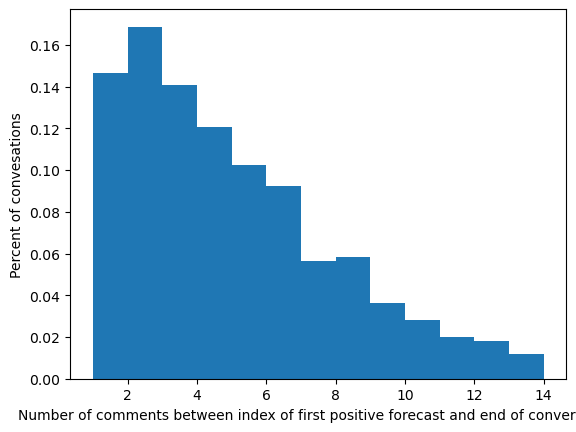

Horizon statistics (# of comments between first positive forecast and conversation end):
Mean = 4.6242544731610336, Median = 4.0


(                 label     score  forecast
 conversation_id                           
 cus26gy              1  0.868554       1.0
 cus37h0              1  0.735048       1.0
 cus142u              0  0.697288       1.0
 cus19ml              0  0.418263       0.0
 cusxft0              1  0.483696       0.0
 ...                ...       ...       ...
 e8qli0i              0  0.445314       0.0
 e8qm4aj              0  0.363978       0.0
 e8ql8ii              0  0.790745       1.0
 e8qzjei              1  0.968748       1.0
 e8r00ko              0  0.778818       1.0
 
 [1368 rows x 3 columns],
 {'Accuracy': 0.6169590643274854,
  'Precision': 0.5945626477541371,
  'Recall': 0.7353801169590644,
  'FPR': 0.5014619883040936,
  'F1': 0.657516339869281})

In [ ]:
craft_forecaster.summarize(corpus, lambda c: c.meta['split'] == "test")